In [131]:
#Etape 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
#Etape 2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from scikitplot.metrics import plot_cumulative_gain, plot_precision_recall, plot_confusion_matrix
from sklearn import preprocessing
import proj_func

In [132]:
#Tableau lois conditionnelles
from IPython.display import display_html
from scikitplot.helpers import cumulative_gain_curve
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
def comparer_cible(name):
    d1 = pd.crosstab(df.loc[df['def12_31']=='0', name], df.loc[df['def12_31']=='0','def12_31'])
    d2 = round(pd.crosstab(df.loc[df['def12_31']=='0', name], df.loc[df['def12_31']=='0','def12_31'], normalize='columns'),2)*100
    d3 = pd.crosstab(df.loc[df['def12_31']=='1', name], df.loc[df['def12_31']=='1','def12_31'])
    d4 = round(pd.crosstab(df.loc[df['def12_31']=='1', name], df.loc[df['def12_31']=='1','def12_31'], normalize='columns'),2)*100    
    df_tmp1 = pd.concat([d1,d2], axis=1, keys=['Effectif', 'Pourcentage'])
    df_tmp2 = pd.concat([d3,d4], axis=1, keys=['Effectif', 'Pourcentage'])
    display_side_by_side(df_tmp1, df_tmp2)
    
def comparer_2dist(name_var,df,x=0):
    df0 = df.loc[df['def12_31']=='0', ]
    df1 = df.loc[df['def12_31']=='1', ]

    fig, ax = plt.subplots()
    sns.distplot(df0[name_var], hist=False, rug=True, color='b')
    sns.distplot(df1[name_var], hist=False,rug=True, color='r')
    ax.legend(('0', '1'), loc='upper right')
    ax.set_xlabel(name_var)
    ax.axvline(x);
    


#SEVERAL LIFT CHART ON THE SAME PLOT
def plot_cumulative_gain(y_true, y_probas, title='Cumulative Gains Curve',ax=None, figsize=None, title_fontsize="large",text_fontsize="medium"):
    """Generates the Cumulative Gains Plot from labels and scores/probabilities
    The cumulative gains chart is used to determine the effectiveness of a
    binary classifier. A detailed explanation can be found at
    http://mlwiki.org/index.php/Cumulative_Gain_Chart. The implementation
    here works only for binary classification.
    Args:
        y_true (array-like, shape (n_samples)):
            Ground truth (correct) target values.
        y_probas (array-like, shape (n_samples, n_classes)):
            Prediction probabilities for each class returned by a classifier.
        title (string, optional): Title of the generated plot. Defaults to
            "Cumulative Gains Curve".
        ax (:class:`matplotlib.axes.Axes`, optional): The axes upon which to
            plot the learning curve. If None, the plot is drawn on a new set of
            axes.
        figsize (2-tuple, optional): Tuple denoting figure size of the plot
            e.g. (6, 6). Defaults to ``None``.
        title_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "large".
        text_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "medium".
    Returns:
        ax (:class:`matplotlib.axes.Axes`): The axes on which the plot was
            drawn.
    Example:
        >>> import scikitplot as skplt
        >>> lr = LogisticRegression()
        >>> lr = lr.fit(X_train, y_train)
        >>> y_probas = lr.predict_proba(X_test)
        >>> skplt.metrics.plot_cumulative_gain(y_test, y_probas)
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe967d64490>
        >>> plt.show()
        .. image:: _static/examples/plot_cumulative_gain.png
           :align: center
           :alt: Cumulative Gains Plot
    """
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    classes = np.unique(y_true)
    if len(classes) != 2:
        raise ValueError('Cannot calculate Cumulative Gains for data with '
                         '{} category/ies'.format(len(classes)))

    # Compute Cumulative Gain Curves
    #percentages, gains1 = cumulative_gain_curve(y_true, y_probas[:, 0],
    #                                            classes[0])
    percentages, gains2 = cumulative_gain_curve(y_true, y_probas[:, 1],
                                                classes[1])

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.set_title(title, fontsize=title_fontsize)

    #ax.plot(percentages, gains1, lw=3, label='Class {}'.format(classes[0]))
    ax.plot(percentages, gains2, lw=3, label='Class {}'.format(classes[1]))

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])

    ax.set_xlabel('Percentage of sample', fontsize=text_fontsize)
    ax.set_ylabel('Gain', fontsize=text_fontsize)
    ax.tick_params(labelsize=text_fontsize)
    ax.grid('on')
    #ax.legend(loc='lower right', fontsize=text_fontsize)
    return ax

def plot_lifts(arg_models, parameters, x_train, x_test, y_train, y_test):
    '''
    arg_models = la liste de model que tu veux tester
    parameters = liste des paramètres à tester ex pour LR et GB : 
    (['learning_rate', 'n_estimators'], ['penalty'])
    '''
    fig ,ax = plt.subplots()
    legend = []
    for count, model in enumerate(arg_models):
        s = type(model).__name__ #+ ' : '
        #for param in parameters[count]:
        #    s += param + ' ' + str(model.get_params()[param]) + ', '        
        #s = s[:-2]
        x = {
            'label': s,
            'model': model, 
        }
        legend.append(x['label'])
        x['model'].fit(x_train, y_train) # train the model
        y_pred_proba =x['model'].predict_proba(x_test) # predict the test data
        plot_cumulative_gain(y_test, y_pred_proba, ax = ax)
    ax.set_title('Lift Chart')
    ax.set_ylabel('TPR')
    ax.legend(legend, loc= 'lower right')
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Baseline')
    fig.savefig('comparaison_models.png', dpi=200)
    
#LIFT TABLE
def lift_table(clf, x_train, x_test, y_train, y_test,n=10):
    clf.fit(x_train, y_train)
    probas = clf.predict_proba(x_test)[:,1] #over_clf.classes_ #['0', '1']
    df = pd.DataFrame({'p':probas, 'y_test':y_test}).sort_values('p', ascending=False)

    tx_cible = len(y_test[y_test == 1])/len(y_test)
    l = np.array_split(df, n, axis=0)
    dic = {'alpha': [], 'effectif':[], 'nb_positif': []}
    for i in range(n):
        df_tmp = l[i]
        dic['alpha'].append(i*1/n+1/n)
        dic['effectif'].append(round(len(df)*1/n)) #effectif
        dic['nb_positif'].append(len(df_tmp[df_tmp['y_test']==1])) #effectif de 1
    res = pd.DataFrame(dic)
    res['pc_positif'] = res['nb_positif']/res['effectif']*100
    res['alpha_lift'] = res['pc_positif']/100/tx_cible
    res['cum_effectif'] = np.cumsum(res['effectif'])
    res['cum_positif'] = np.cumsum(res['nb_positif'])
    res['cum_alpha_lift'] = (res['cum_positif']/res['cum_effectif'])/tx_cible
    return res

def feature_importance(clf, x_train, y_train):
    '''
    plot the 10 most important features
    '''
    clf.fit(x_train, y_train)
    importances = clf.feature_importances_
    df_tmp = pd.concat([pd.Series(importances), pd.Series(x_train.columns)], axis=1)
    df_tmp = df_tmp.sort_values(0, ascending=False)

    fig, ax = plt.subplots()
    ax.barh(df_tmp.iloc[:10,1], df_tmp.iloc[:10,0])
    ax.set_title('features importance')
    ;
    
def plot_ROCs(arg_models, x_train, x_test, y_train, y_test):
    plt.figure()
    
    # Below for loop iterates through your models list
    for count, model in enumerate(arg_models):
        s = type(model).__name__ #+ ' : '
        #for param in parameters[count]:
        #    s += param + ' ' + str(model.get_params()[param]) + ', '        
        #s = s[:-2]
        x = {
            'label': s,
            'model': model, 
        }
        x['model'].fit(x_train, y_train) # train the model
        y_pred=x['model'].predict(x_test) # predict the test data
        # Compute False postive rate, and True positive rate
        fpr, tpr, thresholds = roc_curve(y_test, x['model'].predict_proba(x_test)[:,1], pos_label = 1)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(y_test,model.predict(x_test))
        # Now, plot the computed values
        plt.plot(fpr, tpr, label='%s, AUC = %.1f' % (x['label'], ((auc + 0.2)*100)) + '%')
    # Custom settings for the plot 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(FPR)')
    plt.ylabel('Sensitivity(TPR)')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.savefig('ROC.png', dpi=200)
    plt.show()   # Display

In [133]:
raw_data = pd.read_csv('octroi_RCI.csv', sep = ';', decimal= ',', header=0, parse_dates=['mois_gestion'], dtype = {'STITUATION_FAM':'category', 'MODE_LOGT':'category', 'VN_VO':'category', 'MARQUE':'category', 'anciennete_rci':'category', 'def12_31': 'category'})
df = raw_data.copy()
df = df.drop('mois_gestion', axis=1) #variable inutile
raw_data.head() #(8457, 19)

,ANC_EMPLOI,STITUATION_FAM,MODE_LOGT,AGE_VEH,VN_VO,MARQUE,PRIX_VEH,MT_APPORT,MT_FINANCE,MT_MENS,VR_BALLON,DUREE_CONTRAT,MT_PREST,MT_ASSUR,mois_gestion,age_cli,anciennete_rci,pc_appo,def12_31
0,65,2,1,NaN,VN,REN,19584.65,0.0,19584.65,95.01,19584.63,6,NaN,NaN,2015-01-03,28,1,0,0
1,563,11,2,28.0,VO,REN,16995.00,2123.0,14872.00,312.34,NaN,60,150.0,NaN,2014-01-06,64,3,12,0
2,107,2,2,16.0,VO,REN,19950.00,3869.0,16081.00,329.93,NaN,60,150.0,NaN,2015-01-08,51,3,19,0
3,143,2,2,10.0,VO,REN,17500.00,7143.5,10356.50,217.51,NaN,60,150.0,NaN,2015-01-04,42,4,41,0
4,110,2,NaN,7.0,VO,REN,19740.00,3789.4,15950.60,310.33,7523.04,36,150.0,395.0,2015-01-02,34,4,19,0


# Etape 1 : Description du jeu de données <a id="part1"></a>

## Description des variables <a id="part1sec1"></a>

On dispose de 19 variables :
VARIABLE / SEGMENT / TYPE / EXPECTATION

**VARIABLE CIBLE**
- **def12_31**: indique si la personne a fait défaut 1=Oui / 0=Non. var. quali. 2mod

**FEATURES**

Client
- **age_cli**: Age du client. N
- **ANC_EMPLOI** : Ancienneté à l'emploi. N
- **STITUATION_FAM** : Situation familiale. C (6 mods) (1=Marié, 2=Célib, 3=Divorcé, 4=Veuf, 5=Séparé, 11=Colloc)
- **MODE_LOGT** : Mode de logement C (4 mods) (1=locataire, 2=proprio, 3=autre, 4=chez les parents)
- **anciennete_rci**: Ancienneté relation rci. C (4 mods)
- **mois_gestion**: Mois d'entrée en gestion. C

Contrat
- **pc_appo**: Pourcentage d'apport. N
- **MT_APPORT** : Montant de l'apport. N
- **MT_FINANCE** : Montant financé. N
- **MT_MENS**: Montant de la mensualité. N
- **VR_BALLON**: Montant ballon. N
- **DUREE_CONTRAT**: Durée du contrat. N
- **MT_PREST**:	Montant des prestations. N
- **MT_ASSUR**:	Montant des assurances. N

Véhicule
- **PRIX_VEH** : Prix du véhicule. N
- **AGE_VEH** : Age du véhicule. N
- **MARQUE** : Marque. C
- **VN_VO** : Type de véhicule. C (2 mods : VN=véhicule neuf /VO= véhicule occasion)

On s'attend à ce que les variables age du client, ancienneté à l'emploi, pourcentage d'apport / montant apport, durée du contrat et prix du véhicule soient les vars. les plus importantes.


## Etude de la cible

In [134]:
tab_tmp = pd.crosstab(index = raw_data['def12_31'], columns ='count')
round(tab_tmp/tab_tmp.sum(),3)
pd.concat([tab_tmp,round(tab_tmp/tab_tmp.sum()*100,0)], axis =1, keys= ['Effectif', 'Pourcentage'])

,Effectif,Pourcentage
col_0,count,count
def12_31,,
0,8359,99.0
1,98,1.0


Jeux de données extrêmement déséquilibré : 1% de taux de cible (98 individus). Il va donc être très difficile d'obtenir de bonnes performances compte tenu du jeu de données initial. 

## Valeurs manquantes <a id="part1sec3"></a>


In [135]:
total = raw_data.isnull().sum().sort_values(ascending=False)
percentage = (round(raw_data.isnull().sum()/raw_data.isnull().count(), 3)*100).sort_values(ascending = False)
df_tmp = pd.concat([total, percentage], axis=1, keys=['Total', 'Percent'])
df_tmp[df_tmp['Percent'] >0]

,Total,Percent
anciennete_rci,7271,86.0
MT_ASSUR,6755,79.9
AGE_VEH,6003,71.0
VR_BALLON,5238,61.9
MT_PREST,1280,15.1
MODE_LOGT,108,1.3


In [136]:

#MT_ASSUR
df.loc[df['MT_ASSUR'] ==0] #on ne dispose d'aucune ligne dont le montant d'assurance est nul
df = df.fillna(value={'MT_ASSUR':0}) #on peut imaginer remplacer les NaN par des zéros

#AGE_VEH
df = df.fillna(value={'AGE_VEH':0}) #Les valeurs manquantes correspondent aux véhicules neufs.

#VR_BALLON
df = df.fillna(value={'VR_BALLON':0}) #Les VM correspondent aux personnes qui n'ont pas pris de crédit ballon

#MT_PREST
df = df.fillna(value={'MT_PREST':0}) #Les VM correspondent aux personnes qui n'ont pas pris de préstations supplémentaires


In [137]:
#MODE_LOGT
print('TABLEAU PROFILS COLONNES')
round(pd.crosstab(df['MODE_LOGT'], df['STITUATION_FAM'], normalize = 'columns', margins=True, dropna=True),3)

TABLEAU PROFILS COLONNES


STITUATION_FAM,1,11,2,3,4,5,All
MODE_LOGT,,,,,,,
1,0.102,0.353,0.212,0.223,0.026,0.305,0.137
2,0.883,0.538,0.379,0.702,0.967,0.627,0.764
3,0.004,0.058,0.013,0.008,0.000,0.017,0.008
4,0.011,0.052,0.397,0.066,0.007,0.051,0.091


**Rappel :** 

- situation_fam  (1=Marié, 2=Célib, 3=Divorcé, 4=Veuf, 5=Séparé, 11=Colloc)
- MODE_LOGT Mode de logement C (4 mods) (1=locataire, 2=proprio, 3=autre, 4=chez les parents) "

**Retour sur la variable mode de logement** :

- 1 (61 valeurs) : Parmi les gens mariés, 88% sont proprios
- 2 (36 valeurs) : Parmi les gens célibataires, c'est plus compliqué.. 1,2 ou 4..
- 4 (1 valeurs) : Parmi les veufs, 96% sont proprios 
- 5 (4 valeurs) : Parmi les séparés, env 60% proprios, 30% loc
- 11 (6 valeurs) : Parmi les colocs, env 55% sont proprios et 35% sont locataires

Il y 80% d'être proprio quand on est marié. On décide de remplacer les NA Mode Logt des mariés par proprio et on se débarrasse des autres lignes. 

In [138]:
df.loc[(df['MODE_LOGT'].isna()) & (df['STITUATION_FAM']=='1'),['MODE_LOGT']] = '2'
df.loc[(df['MODE_LOGT'].isna()) & (df['STITUATION_FAM']=='11'),['MODE_LOGT']] = '2'
df.loc[(df['MODE_LOGT'].isna()) & (df['STITUATION_FAM']=='4'),['MODE_LOGT']] = '2'
df.loc[(df['MODE_LOGT'].isna()) & (df['STITUATION_FAM']=='5'),['MODE_LOGT']] = '2'

 ## Vérification après analyse des Valeurs Manquantes 

In [139]:
df.isnull().sum().sort_values(ascending=False)

anciennete_rci    7271
MODE_LOGT           36
def12_31             0
MT_APPORT            0
STITUATION_FAM       0
AGE_VEH              0
VN_VO                0
MARQUE               0
PRIX_VEH             0
MT_FINANCE           0
pc_appo              0
MT_MENS              0
VR_BALLON            0
DUREE_CONTRAT        0
MT_PREST             0
MT_ASSUR             0
age_cli              0
ANC_EMPLOI           0
dtype: int64

## Analyse des vars. quantitatives


In [140]:
num_feats = df.dtypes[(df.dtypes != 'category')].index
list(num_feats) #12

['ANC_EMPLOI',
 'AGE_VEH',
 'PRIX_VEH',
 'MT_APPORT',
 'MT_FINANCE',
 'MT_MENS',
 'VR_BALLON',
 'DUREE_CONTRAT',
 'MT_PREST',
 'MT_ASSUR',
 'age_cli',
 'pc_appo']

**Un exemple de la méthode utilisée :**

On va se pencher sur chaque variable quantitative pour la discrétiser pour ensuite transformer l'intégralité de nos variables en dummies. L'idée est de créer des classes qui permettent de discriminer les deux groupes. On doit aussi s'assurer que chaque classe est suffisamment grande (> à 5 obs.)

Essayons d'illuster notre propos avec la variable **"age du client" :**



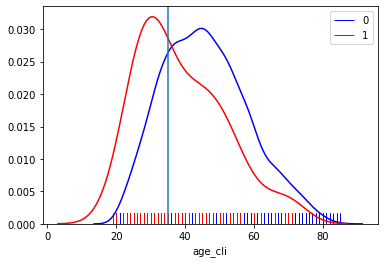

In [141]:
comparer_2dist('age_cli',df,35)

On observe que une queue de distribution à droite pour les gens qui ne font pas défaut, à gauche pour les gens qui font défaut. La variable Age permet de discriminer les 2 groupes

In [142]:
df['age_cli_CAT'] = pd.cut(df['age_cli'], precision=0, bins= 3)

In [143]:
comparer_cible('age_cli_CAT')

,Effectif,Pourcentage
def12_31,0,0
age_cli_CAT,,
"(19.0, 41.0]",3301,39.0
"(41.0, 63.0]",4268,51.0
"(63.0, 85.0]",790,9.0
,Effectif,Pourcentage
def12_31,1,1
age_cli_CAT,,
"(19.0, 41.0]",61,62.0
"(41.0, 63.0]",32,33.0


In [144]:
#ANC_EMPLOI
df['ANC_EMPLOI'] = df['ANC_EMPLOI']/12
df['ANC_EMPLOI_CAT'] = 0
df.loc[(df['ANC_EMPLOI']<=5), ['ANC_EMPLOI_CAT']] = '(0, 5]'
df.loc[(df['ANC_EMPLOI']>5) & (df['ANC_EMPLOI']<=10), ['ANC_EMPLOI_CAT']] = '(5, 10]'
df.loc[(df['ANC_EMPLOI']>10) & (df['ANC_EMPLOI']<=20), ['ANC_EMPLOI_CAT']] = '(10, 20]'
df.loc[(df['ANC_EMPLOI']>20), ['ANC_EMPLOI_CAT']] = '(20, .]'

#AGE_VEH
df['AGE_VEH_CAT'] = 0
df.loc[(df['AGE_VEH']==0), ['AGE_VEH_CAT']] = '0'
df.loc[(df['AGE_VEH']>0) & (df['AGE_VEH']<=40), ['AGE_VEH_CAT']] = '(0,40]'
df.loc[(df['AGE_VEH']>40), ['AGE_VEH_CAT']] = '(40,.]'

#PRIX_VEH
df['PRIX_VEH_CAT'] = 0
df.loc[(df['PRIX_VEH']<=13000), ['PRIX_VEH_CAT']] = '(0,13000]'
df.loc[(df['PRIX_VEH']>13000), ['PRIX_VEH_CAT']] = '(13000,.]'

#MT_APPORT
df['MT_APPORT_CAT'] = 0
df.loc[(df['MT_APPORT']<=3000), ['MT_APPORT_CAT']] = '(0,3000]'
df.loc[(df['MT_APPORT']>3000), ['MT_APPORT_CAT']] = '(3000,.]'

#pc_apport
df['pc_appo_CAT'] = 0
df.loc[df['pc_appo']<=22, ['pc_appo_CAT']] = '(0, 22]'
df.loc[(df['pc_appo']>22), ['pc_appo_CAT']] = '(22, .]'

#MT_FINANCE
df['MT_FINANCE_CAT']=0
df.loc[(df['MT_FINANCE']<=9000), ['MT_FINANCE_CAT']] = '(0,9000]'
df.loc[(df['MT_FINANCE']>9000) & (df['MT_FINANCE']<=12000), ['MT_FINANCE_CAT']] = '(9000,12000]'
df.loc[(df['MT_FINANCE']>12000), ['MT_FINANCE_CAT']] = '(12000,.]'

#VR_BALLON
df['VR_BALLON_CAT'] = 0
df.loc[(df['VR_BALLON']==0), ['VR_BALLON_CAT']] = '0'
df.loc[(df['VR_BALLON']>0), ['VR_BALLON_CAT']] = '>0'

#DUREE_CONTRAT
df['DUREE_CONTRAT_CAT'] = 0
df.loc[(df['DUREE_CONTRAT']<=30), ['DUREE_CONTRAT_CAT']] = '(0,30]'
df.loc[(df['DUREE_CONTRAT']>30) & (df['DUREE_CONTRAT']<=40), ['DUREE_CONTRAT_CAT']] = '(30, 40]'
df.loc[(df['DUREE_CONTRAT']>40), ['DUREE_CONTRAT_CAT']] = '(40,.]'

#MT_PREST
df['MT_PREST_CAT'] = 0
df.loc[(df['MT_PREST']==150), ['MT_PREST_CAT']] = '150'
df.loc[(df['MT_PREST']!=150), ['MT_PREST_CAT']] = 'autre'

#MT_ASSUR
df['MT_ASSUR_CAT'] = 0
df.loc[(df['MT_ASSUR']==0), ['MT_ASSUR_CAT']] = '0'
df.loc[(df['MT_ASSUR']>0), ['MT_ASSUR_CAT']] = '>0'

#MT_MENS
df['MT_MENS_CAT'] = 250
df.loc[(df['MT_MENS']<250), ['MT_MENS_CAT']] = '(0,250]'
df.loc[(df['MT_MENS']>=250), ['MT_MENS_CAT']] = '(250,.]'

## Analyse des variables qualitatives

Cette fois-ci les variables considérée sont déjà catégorielles. Il n'est pas nécessaire de créer des classes. En revanche il faut s'assurer que chaque modalité est pertinente, c'est à dire que chaque modalité présente plus de 5 individus. On va réarranger nos variables catégorielles en ce sens

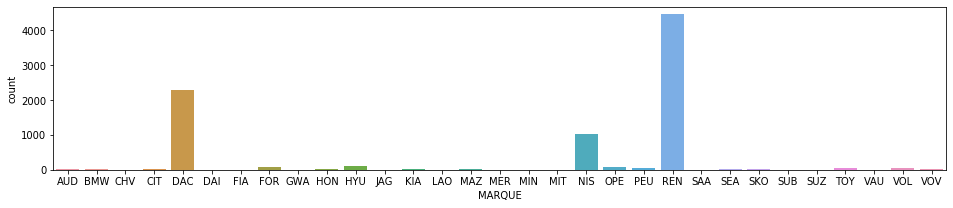

In [145]:
#SITUATION_FAM
df['STITUATION_FAM_CAT'] = 0
df.loc[df['STITUATION_FAM'].isin(['11', '4','5']), ['STITUATION_FAM_CAT']] = 'autre'
df.loc[df['STITUATION_FAM'] == '1', ['STITUATION_FAM_CAT']] = 'marie'
df.loc[df['STITUATION_FAM'] == '2', ['STITUATION_FAM_CAT']] = 'celibataire'

#MARQUE 
plt.figure(figsize=(16,3))
sns.countplot(df['MARQUE']);

On réduit le nombre de modalité à 2 : 'groupe renault' et 'autre'. 

In [146]:
df['MARQUE_CAT'] =0
df.loc[df['MARQUE'].isin(['REN', 'NIS', 'DAC']),['MARQUE_CAT']] = 'groupe_renault'
df.loc[-df['MARQUE'].isin(['REN', 'NIS', 'DAC']),['MARQUE_CAT']] = 'autre'

In [147]:
#On se débarasse de l'ancienne variable Marque
df = df.drop(['MARQUE'], axis=1)

## Feature Engeneering

Pour améliorer les performances de notre modèle, on créer de nouvelles variables. Il s'agit essentiellement de variables métier et de ratio qui nous ont semblés intéressants. 

In [148]:
#PRIX_TOTAL
df = df.assign(PRIX_TOTAL = df['PRIX_VEH']+df['MT_APPORT']+df['MT_PREST'] + df['VR_BALLON']+df['MT_ASSUR'])

#MENS_par_FINANCE
df = df.assign(MENS_par_FINANCE= df['MT_MENS']/df['MT_FINANCE'])

#PREST_par_FINANCE
df = df.assign(PREST_par_FINANCE= df['MT_PREST']/df['MT_FINANCE'])

#ASSUR_par_FINANCE
df = df.assign(ASSUR_par_FINANCE= df['MT_ASSUR']/df['MT_FINANCE'])

#age_cli_par_DUREE
df = df.assign(age_cli_par_DUREE= df['age_cli']/df['DUREE_CONTRAT'])

#DUREE_C_par_FINANCE
df = df.assign(DUREE_C_par_FINANCE= df['DUREE_CONTRAT']/df['MT_FINANCE'])

In [149]:
#On transforme ces variables en vars. quali
eng_feats = ['PRIX_TOTAL', 'MENS_par_FINANCE', 'DUREE_C_par_FINANCE', \
'PREST_par_FINANCE', 'ASSUR_par_FINANCE', 'age_cli_par_DUREE']
cat_feats = list(df.dtypes[df.dtypes == 'object'].index)
for col in cat_feats:
    df[col] = df[col].astype('category',copy=False)

#On se débarassse des précédentes vars. quali
#old_cat_feats = ['ANC_EMPLOI','AGE_VEH','PRIX_VEH', 'MT_APPORT', 'pc_appo', 'MT_FINANCE',\
# 'VR_BALLON', 'DUREE_CONTRAT', 'MT_PREST', 'MT_ASSUR', 'MT_MENS', 'STITUATION_FAM', 'MARQUE']
#df = df.drop(old_cat_feats, axis=1)

## Vérification et transformation en dummies

In [150]:
df.info()
df.shape #(8457, 38) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8457 entries, 0 to 8456
Data columns (total 37 columns):
ANC_EMPLOI             8457 non-null float64
STITUATION_FAM         8457 non-null category
MODE_LOGT              8421 non-null category
AGE_VEH                8457 non-null float64
VN_VO                  8457 non-null category
PRIX_VEH               8457 non-null float64
MT_APPORT              8457 non-null float64
MT_FINANCE             8457 non-null float64
MT_MENS                8457 non-null float64
VR_BALLON              8457 non-null float64
DUREE_CONTRAT          8457 non-null int64
MT_PREST               8457 non-null float64
MT_ASSUR               8457 non-null float64
age_cli                8457 non-null int64
anciennete_rci         1186 non-null category
pc_appo                8457 non-null int64
def12_31               8457 non-null category
age_cli_CAT            8457 non-null category
ANC_EMPLOI_CAT         8457 non-null category
AGE_VEH_CAT            8457 non-null 

(8457, 37)

In [151]:
df = df.drop('def12_31', axis=1)
df = pd.get_dummies(df)

In [152]:
#vérification 
df.shape

(8457, 71)

In [153]:
np.where(df.isna())
df.isna().sum(axis=0).sort_values(ascending=False)

MARQUE_CAT_groupe_renault    0
MODE_LOGT_2                  0
STITUATION_FAM_11            0
STITUATION_FAM_2             0
STITUATION_FAM_3             0
                            ..
MT_APPORT_CAT_(0,3000]       0
MT_APPORT_CAT_(3000,.]       0
pc_appo_CAT_(0, 22]          0
pc_appo_CAT_(22, .]          0
ANC_EMPLOI                   0
Length: 71, dtype: int64

# Etape 2 : 

## Cross-validation stratifiée :

On sépare notre jeu de données initiale en un jeu d'entrainement (train set) et un jeu de validation (test set). Il est crucial d'avoir le même taux de cible dans les 2 jeux de données (~1%)

In [154]:
#Cross validation 
y = raw_data['def12_31']
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size= 0.3, stratify=y, random_state=1) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5919, 71) (2538, 71) (5919,) (2538,)


## Rééchantillonnage : méthode SMOTE

Le but de cette méthode de sur-échantillonnage est de créer artificiellement des données de la classe '1' à partir des 98 individus qui font défaut. 


(11700, 71)


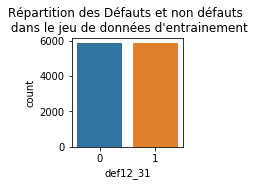

In [155]:
#SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, k_neighbors=5).fit_resample(X_train, y_train)
#Vérification
print(X_resampled.shape)
fig, ax = plt.subplots(figsize=(2,2))
sns.countplot('def12_31', data=pd.concat([X_resampled,y_resampled], axis=1))
ax.set_title('Répartition des Défauts et non défauts \n dans le jeu de données d\'entrainement');

## Standardisation des données


In [156]:
X_sc_resampled = pd.DataFrame(preprocessing.scale(X_resampled), columns=X_resampled.columns)
X_sc_test = pd.DataFrame(preprocessing.scale(X_test), columns= X_test.columns)

In [157]:
#On s'assure que les données soient dans le bon format
y_resampled = y_resampled.astype('uint8')
y_train = y_train.astype('uint8')
y_test = y_test.astype('uint8')

## 1er modèle : Régression Logistique 

In [158]:
params = {
    'penalty':('l2', 'none'), 
    'C': (0.001, 0.01, 0.1),
    'solver': ['newton-cg', 'lbfgs', 'sag'],    
    'l1_ratio': np.arange(0.1,0.9,0.1),
}

lr_clf = GridSearchCV(
    estimator = LogisticRegression(max_iter=10000),
    param_grid = params,
    cv = 5, #specify the number of folds in a (Stratified)KFold
    scoring =['precision', 'recall', 'f1'],
    refit = 'f1',
    n_jobs = -1, #1 pas de parallélisation / -1 parallélisation
    verbose=1
    )
    
#lr_clf.fit(X_sc_resampled, y_resampled)

On obtient notre meilleur classifier pour la régression logistique : 

In [159]:
lr_clf = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)

In [160]:
table_lift = lift_table(lr_clf, X_sc_resampled, X_sc_test, y_resampled, y_test)
table_lift

,alpha,effectif,nb_positif,pc_positif,alpha_lift,cum_effectif,cum_positif,cum_alpha_lift
0,0.1,254,11,4.330709,3.790117,254,11,3.790117
1,0.2,254,5,1.968504,1.722780,508,16,2.756449
2,0.3,254,2,0.787402,0.689112,762,18,2.067336
3,0.4,254,2,0.787402,0.689112,1016,20,1.722780
4,0.5,254,4,1.574803,1.378224,1270,24,1.653869
5,0.6,254,2,0.787402,0.689112,1524,26,1.493076
6,0.7,254,2,0.787402,0.689112,1778,28,1.378224
7,0.8,254,1,0.393701,0.344556,2032,29,1.249016
8,0.9,254,0,0.000000,0.000000,2286,29,1.110236
9,1.0,254,0,0.000000,0.000000,2540,29,0.999213


# Etape 3 : Modèles ensemblistes : Boosting & Random Forest 


## Boosting 

Le boosting dans cet exemple donne de mauvais résultats. On ne s'attardera donc pas sur cet algorithme. 

In [161]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.01, n_estimators= 1500, max_depth=4, min_samples_split=2, min_samples_leaf=1,
                               subsample=1, max_features='sqrt')

lift_table(gb_clf, X_sc_resampled, X_sc_test, y_resampled, y_test)

,alpha,effectif,nb_positif,pc_positif,alpha_lift,cum_effectif,cum_positif,cum_alpha_lift
0,0.1,254,3,1.181102,1.033668,254,3,1.033668
1,0.2,254,7,2.755906,2.411892,508,10,1.722780
2,0.3,254,5,1.968504,1.722780,762,15,1.722780
3,0.4,254,2,0.787402,0.689112,1016,17,1.464363
4,0.5,254,4,1.574803,1.378224,1270,21,1.447135
5,0.6,254,2,0.787402,0.689112,1524,23,1.320798
6,0.7,254,0,0.000000,0.000000,1778,23,1.132113
7,0.8,254,4,1.574803,1.378224,2032,27,1.162877
8,0.9,254,1,0.393701,0.344556,2286,28,1.071952
9,1.0,254,1,0.393701,0.344556,2540,29,0.999213


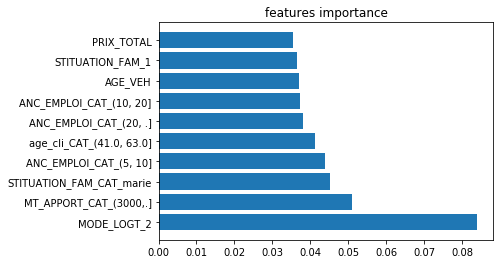

In [162]:
feature_importance(gb_clf, X_sc_resampled, y_resampled)

## Random Forest

In [163]:
#GridSearch

param_grid = { 
    #'bootstrap': [True, False],
    'n_estimators': [200, 400, 600],
    'max_features': ['auto','sqrt'],
    'max_depth' : [2,3,4,5,6],
    'criterion' :['gini', 'entropy']
}

rf_clf = GridSearchCV(estimator= RandomForestClassifier(random_state=1),
                      param_grid=param_grid,
                      cv= 5,
                      verbose = 5,
                      scoring = ('precision', 'recall', 'f1'),
                      refit = 'f1',
                      n_jobs = -1)

##à dé-commenter si vous souhaitez lancer le gridsearch
#rf_clf.fit(X_sc_resampled, y_resampled)
#res = pd.DataFrame(rf_clf.cv_results_)
#feats = ['param_criterion', 'param_max_depth', 'param_max_features','param_n_estimators',\
#         'mean_test_precision','mean_test_recall','mean_test_f1', 'rank_test_f1']
#res[feats].sort_values('rank_test_f1').head(5)

On obtient notre meilleur classifier pour le random Forest :

In [164]:
rf_clf = RandomForestClassifier(n_estimators = 600,
                            max_features = 'sqrt', 
                            max_depth = 2,
                            criterion = 'gini', 
                            random_state = 1,
                            verbose = 0)
rf_clf.fit(X_sc_resampled, y_resampled)

y_pred = rf_clf.predict(X_sc_test)

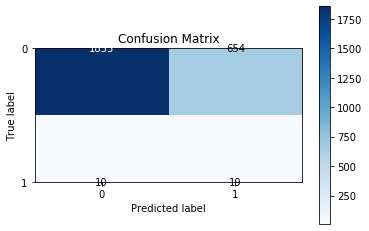

In [165]:
plot_confusion_matrix(y_test, y_pred);

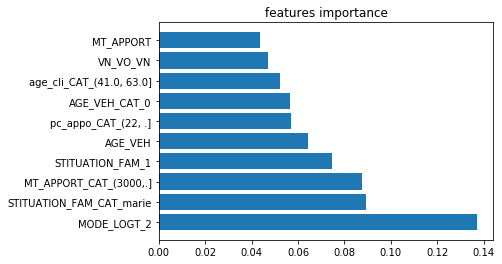

In [166]:
feature_importance(rf_clf, X_sc_resampled, y_resampled)

In [167]:
table_lift = lift_table(rf_clf, X_sc_resampled, X_sc_test, y_resampled, y_test)
table_lift

,alpha,effectif,nb_positif,pc_positif,alpha_lift,cum_effectif,cum_positif,cum_alpha_lift
0,0.1,254,10,3.937008,3.445561,254,10,3.445561
1,0.2,254,5,1.968504,1.722780,508,15,2.584171
2,0.3,254,6,2.362205,2.067336,762,21,2.411892
3,0.4,254,2,0.787402,0.689112,1016,23,1.981197
4,0.5,254,0,0.000000,0.000000,1270,23,1.584958
5,0.6,254,3,1.181102,1.033668,1524,26,1.493076
6,0.7,254,1,0.393701,0.344556,1778,27,1.329002
7,0.8,254,1,0.393701,0.344556,2032,28,1.205946
8,0.9,254,0,0.000000,0.000000,2286,28,1.071952
9,1.0,254,1,0.393701,0.344556,2540,29,0.999213


## Meilleur modèle et performances finales

### Courbes Lifts :

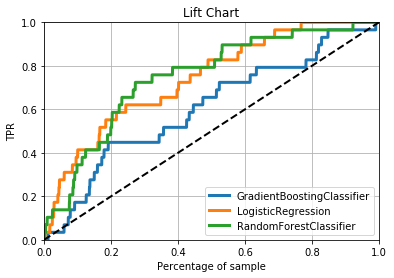

In [168]:
arg_models = [
    #Meilleur GB
    GradientBoostingClassifier(learning_rate = 0.05, n_estimators= 250, max_depth=4, min_samples_split=2, min_samples_leaf=1,
                               subsample=1, max_features='sqrt'), 
    #Meilleur LR
    LogisticRegression(penalty='l1', solver='liblinear', C=10),
    #Meilleur RF
    RandomForestClassifier(n_estimators= 600, 
                           max_features='sqrt', 
                           max_depth=2, 
                           criterion='gini', 
                           random_state=1)
]
    
plot_lifts(arg_models,([], \
[], []), X_sc_resampled, X_sc_test, y_resampled, y_test)

### Courbes ROCs et AUC :

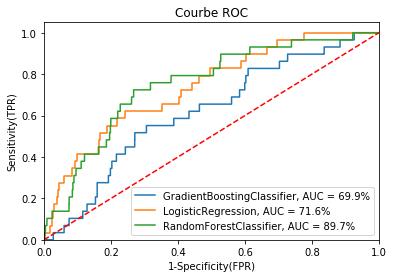

<Figure size 432x288 with 0 Axes>

In [169]:
plot_ROCs(arg_models, X_sc_resampled, X_sc_test, y_resampled, y_test)